In [1]:
%matplotlib inline
import netCDF4 
import pandas as pd
import matplotlib.cm as cm
import matplotlib 
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

sea_ice = netCDF4.Dataset('data/G10010_SIBT1850_v1.1.nc','r')

lat = sea_ice.variables['latitude'][:]
lon = sea_ice.variables['longitude'][:]
seaice_conc = sea_ice.variables['seaice_conc'][:]
seaice_source = sea_ice.variables['seaice_source'][:]
time = sea_ice.variables['time'][:]


In [4]:
def time_slice(t):
    # t ranges from -55138 to 4731
    # return 240x1440 array of concentration at lon/lat at the given time
    if t in time:
        t_index = np.where( time==t )
        
        return seaice_conc[t_index][0]
    else:
        closest_neighbor = np.abs(time-t).min()
        t_index = np.where( time==closest_neighbor )
        
        return seaice_conc[t_index][0]

def draw_screen_poly( lat_min, lat_max, lon_min, lon_max, m):
    #x, y = m( lons, lats )
    #xy = zip(x,y)
    #poly = Polygon( xy, facecolor='red', alpha=0.4 )
    #plt.gca().add_patch(poly)

    x1,y1 = m(-25,-25)
    x2,y2 = m(-25,25)
    x3,y3 = m(25,25)
    x4,y4 = m(25,-25)
    
    poly = Polygon([(lon_min,lat_min),
                    (lon_min,lat_max),
                    (lon_max,lat_min),
                    (lon_max,lat_max)],
                   facecolor='black',edgecolor='green',linewidth=3, zorder=50)
    plt.gca().add_patch( poly )
    plt.show()

    

def plot_roi_patch(latmin,latmax,lonmin,lonmax, map):

    x1,y1 = map(lonmax, latmax)   # lon_max, lat_max
    x2,y2 = map(lonmax, latmin)   # lon_max, lat_min
    xmid1, ymid1 = map( (lonmax+lonmin)/2, latmin  )
    x3,y3 = map(lonmin, latmin)   # lon_min, lat_min
    x4,y4 = map(lonmin, latmax)  # lon_min, lat_max
    xmid2, ymid2 = map( (lonmax+lonmin)/2, latmax  )

    boundary=[]
    boundary.append([x1,y1])
    boundary.append([x2,y2])

    for n in range((lonmax-lonmin)*3):
        xx,yy = map(lonmax-(n+1)/3., latmin)
        boundary.append([xx,yy])

    boundary.append([x3,y3])
    boundary.append([x4,y4])

    for n in range((lonmax-lonmin)*3):
        xx,yy = map(lonmin+(n+1)/3., latmax)
        boundary.append([xx,yy])

    p = Polygon(boundary,
        facecolor='red',edgecolor='blue',linewidth=2, alpha=0.75)
    plt.gca().add_patch(p) 


    
def plot_seaice_at_t(year=2000, Month=3, saveFig=False):
    #t = 4731
    
    t_index = (year-1850)*12 + (Month-1)
    
    lats = lat[:]
    lons = lon[:]
    lons, lats = np.meshgrid(lons,lats)

    map= Basemap(projection='npstere',boundinglat=50,lon_0=270,resolution='l')

    fig = plt.figure(figsize=(9,9))
    ax=fig.add_subplot(111)

    im1 = map.pcolormesh(lons,lats, time_slice(time[t_index]),
                         shading='flat',
                         cmap=cm.seismic, #vmin=80, vmax=90,
                         latlon=True, 
                         alpha=0.3,
                        zorder=0)
    cb = map.colorbar(im1,"bottom", size="5%", pad="2%", )

    cb.set_clim(-50, 150)

    map.drawparallels(np.arange(50.,90.,10.), labels=[0,0,0,0], color='linen', zorder=30)
    map.drawmeridians(np.arange(-180.,181.,20.),latmax=90, labels=[0,0,0,0], color='linen', 
                      zorder=30)
    map.drawcoastlines(linewidth=0.3)
    map.fillcontinents(color='chocolate',lake_color='darkblue', alpha=0.7, zorder=20)
    map.drawmapboundary(fill_color='powderblue', linewidth=0.5)
    
    month_arr= ['January','February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    
    ax.set_title('Sea Ice Concentration, '+month_arr[Month-1]+' '+repr(year))
    if saveFig==True:
        plt.savefig('./figures/conc_'+repr(Month)+'_'+repr(year)+'.png')
    
    
def TimeSeries_sea_ice_change_in_roi(lonmin, lonmax, latmin, latmax, selectMonth=False, Month=3, last_N_years=0):
    # if selectMonth=True, only returns ice concentration for the selected Month (1=Jan, 2=Feb, etc.)
    minlat_index = np.argmin(abs(lat-latmin))
    maxlat_index = np.argmin(abs(lat-latmax))
    minlon_index = np.argmin(abs(lon-lonmin))
    maxlon_index = np.argmin(abs(lon-lonmax))

    roi_conc_cube = seaice_conc[:,maxlat_index:minlat_index,minlon_index:maxlon_index]
    
    time_arr = []
    conc_time_series=[]
    
    num_points = 0  #roi_conc_cube.shape[1] * roi_conc_cube.shape[2]
    N_years = int(len(time)/12)
  
    if selectMonth==False:
        xdim, ydim = roi_conc_cube[0].shape[0], roi_conc_cube[0].shape[1]
        
        for t in range(roi_conc_cube.shape[0]):
            time_arr.append(time[t])
            sum=0.
            Npoints=0
            
            for x in range(xdim):
                for y in range(ydim):
                    elem = roi_conc_cube[t][x][y]
                    if elem>-0.1:
                        sum+=elem
                        Npoints+=1
            conc_time_series.append( sum/Npoints )
    else:
        xdim, ydim = roi_conc_cube[0].shape[0], roi_conc_cube[0].shape[1]
        for y in range(0,N_years):
            index = y*12 + Month
            time_arr.append( time[index] )
            sum=0.
            Npoints=0

            for x in range(xdim):
                for y in range(ydim):
                    elem = roi_conc_cube[index][x][y]
                    if elem>-0.1:
                        sum+=elem
                        Npoints+=1
            conc_time_series.append( sum/Npoints )
            #conc_time_series.append( roi_conc_cube[index].sum() / num_points ) 
            
    #adjusted_time, conc_time_series = TS[0], TS[1]
    adjusted_time = time_arr - np.min(time_arr)

    time_years = []
    for d in range(len(adjusted_time)):
        time_years.append(1850+d)

    fig=plt.figure(figsize=(8,5))
    ax=fig.add_subplot(111)
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Ice Concentration [%]')
    ax.plot(time_years[-last_N_years:], conc_time_series[-last_N_years:], '-')
    month_arr= ['January','February', 'March', 'April', 'May', 'June','July','August','September','October','November','December']
    if selectMonth==True:
        ax.set_title(month_arr[Month-1])



def plot_icechange(Month1=9, Month2=9, year1=1990, year2=2013, saveFig=False):
    
    t_index1 = (year1-1850)*12 + (Month1-1)
    t_index2 = (year2-1850)*12 + (Month2-1)
    

    lats = lat[:]
    lons = lon[:]
    lons, lats = np.meshgrid(lons,lats)

    diff_slice = time_slice( time[t_index2] ) - time_slice( time[t_index1] )
    
    map= Basemap(projection='npstere',boundinglat=50,lon_0=270,resolution='l')


    fig = plt.figure(figsize=(9,9))
    ax=fig.add_subplot(111)

    im1 = map.pcolormesh(lons,lats, diff_slice,
                         shading='flat',
                         cmap=cm.seismic, vmin=-100, vmax=100,
                         latlon=True, 
                         alpha=0.7)
                        #zorder=0)
    cb = map.colorbar(im1,"bottom", size="5%", pad="2%", )

    #cb.set_clim(-50, 150)

    map.drawparallels(np.arange(50.,90.,10.), labels=[0,0,0,0], color='grey', alpha=0.7, zorder=30)
    map.drawmeridians(np.arange(-180.,181.,20.),latmax=90, labels=[0,0,0,0], color='grey', 
                      zorder=30)
    map.drawcoastlines(linewidth=0.3)
    map.fillcontinents(color='chocolate',lake_color='darkblue', alpha=0.7, zorder=20)
    map.drawmapboundary(fill_color='lightblue', zorder=-100)

    map.drawmapboundary(fill_color='brown', linewidth=0.5)
    month_arr= ['January','February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    
     
    ax.set_title( 'Change in Sea Ice Concentration, '+ month_arr[Month1-1] +' '+ repr(int(year1))+' - '+ month_arr[Month2-1]+' '+repr(int(year2)) ) 
    
    if saveFig==True:
        plt.savefig('./figures/delta_conc_'+repr(Month1)+'_'+repr(year1)+'_to_'+repr(Month2)+'_'+repr(year2)+'.png')

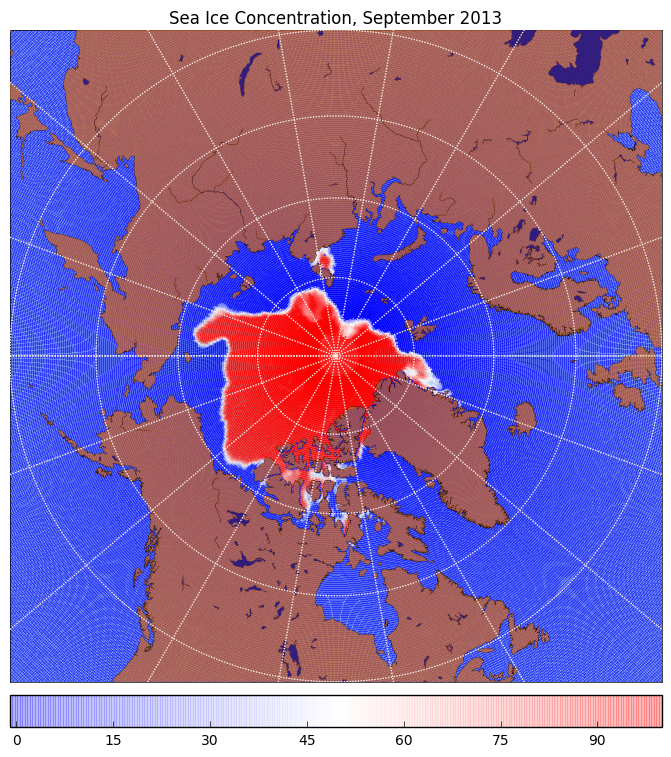

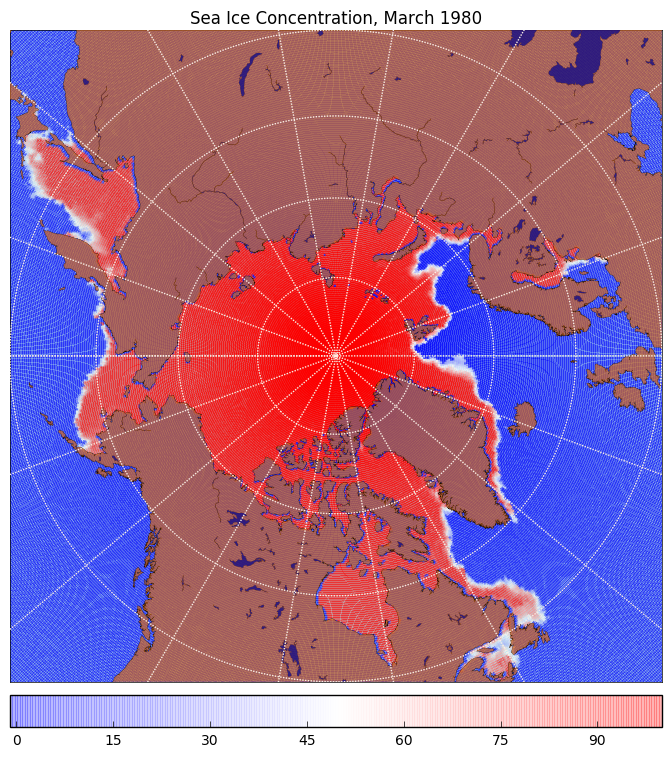

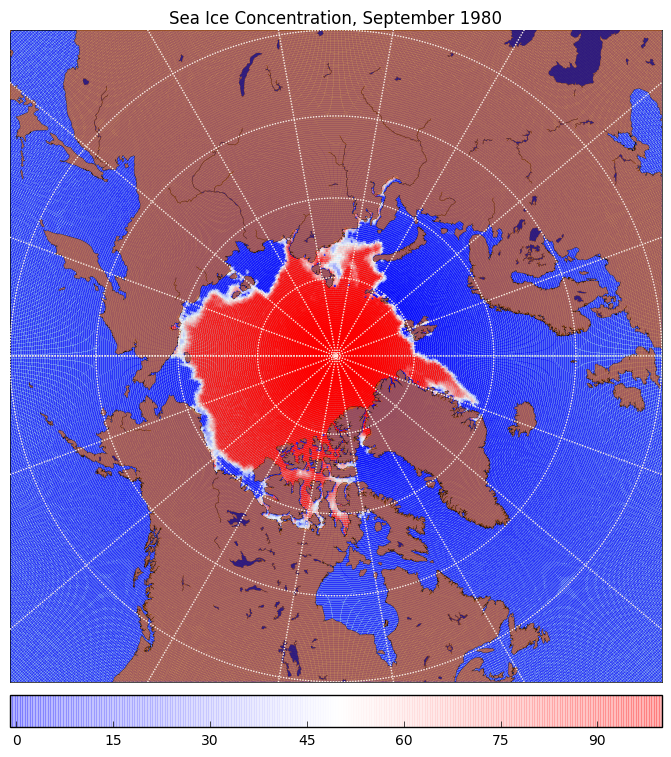

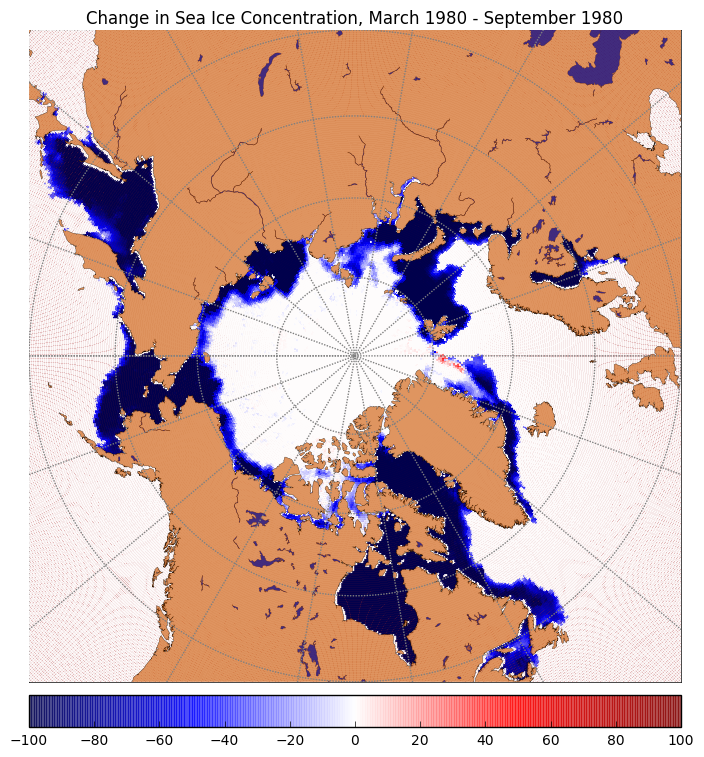

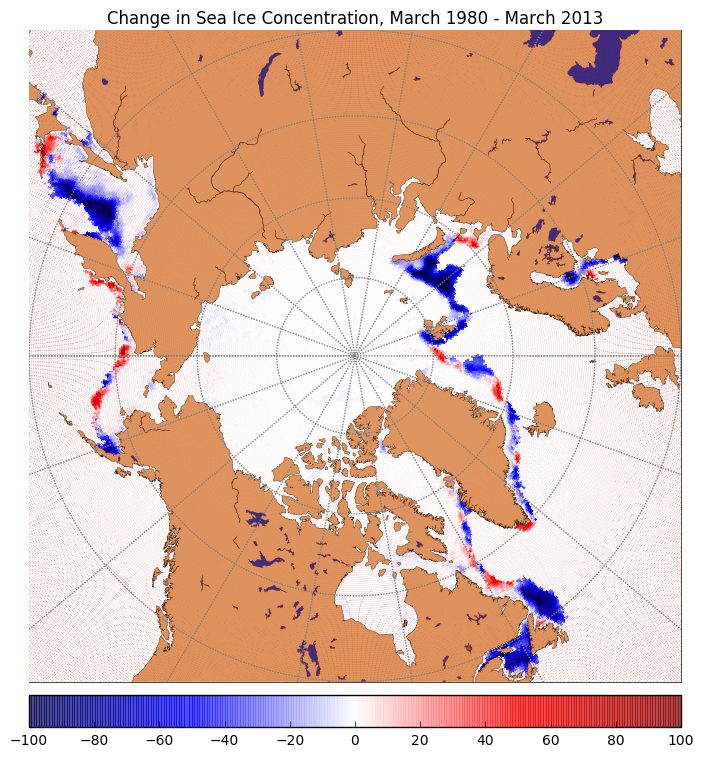

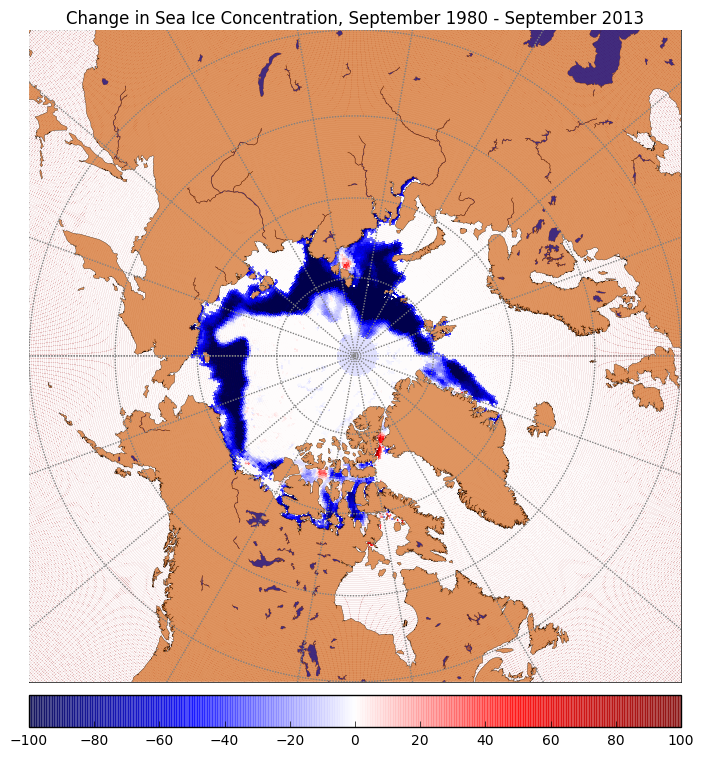

In [5]:
# sea ice concentration at month/year
plot_seaice_at_t( year=2013, Month=3, saveFig=True )
plot_seaice_at_t( year=2013, Month=9 , saveFig=True)
plot_seaice_at_t( year=1980, Month=3, saveFig=True )
plot_seaice_at_t( year=1980, Month=9 , saveFig=True)

# seasonal change in one single year
plot_icechange(Month1=3, Month2=9, year1=2013, year2=2013, saveFig=True)
plot_icechange(Month1=3, Month2=9, year1=1980, year2=1980, saveFig=True)
               
# change between years in the same month
plot_icechange(Month1=3, Month2=3, year1=1980, year2=2013, saveFig=True)
plot_icechange(Month1=9, Month2=9, year1=1980, year2=2013, saveFig=True)


## Sea Ice Concentration: 1980 vs. 2013

March 1980 | March 2013
:-------------------------:|:-------------------------:
![](./figures/conc_3_1980.png)  |  ![](./figures/conc_3_2013.png)


September 1980 | September 2013
:-------------------------:|:-------------------------:
![](./figures/conc_9_1980.png)  |  ![](./figures/conc_9_2013.png)

## Change in Sea Ice Concentration: 1980 vs. 2013

$\Delta$ March ice | $\Delta$ September ice
:-------------------------:|:-------------------------:
![](./figures/delta_conc_3_1980_to_3_2013.png)  |  ![](./figures/delta_conc_9_1980_to_9_2013.png)

## Sea Ice Concentration: end of winter vs. end of summer
March 2013 |September 2013
:-------------------------:|:-------------------------:
![](./figures/conc_3_2013.png)  |  ![](./figures/conc_9_2013.png)

March 1980 |September 1980
:-------------------------:|:-------------------------:
![](./figures/conc_3_1980.png)  |  ![](./figures/conc_9_1980.png)

## Seasonal changes in Sea Ice Concentration: 2013 vs 1980

Seasonal Change: 1980 |Seasonal Change: 2013
:-------------------------:|:-------------------------:
![](./figures/delta_conc_3_1980_to_9_1980.png)  |  ![](./figures/delta_conc_3_2013_to_9_2013.png)

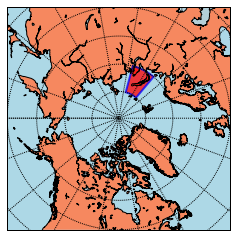

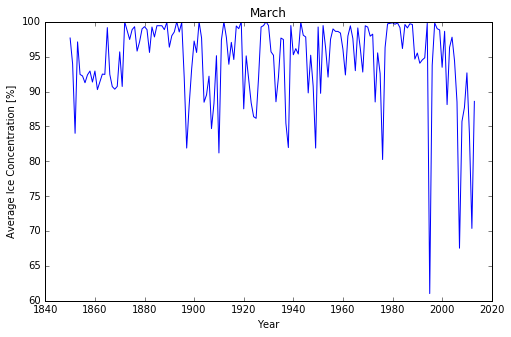

In [6]:
map = Basemap(projection='npstere',boundinglat=50,lon_0=270,resolution='l') 

map.fillcontinents(color='coral',lake_color='lightblue', alpha=0.9, zorder=-20)
map.drawcoastlines() 
map.drawmapboundary(fill_color='lightblue')
map.drawparallels(np.arange(40.,90.,10))
map.drawmeridians(np.arange(-180.,181.,20.),latmax=90)

# north of Sweden
latmin, latmax= 70,80
lonmin, lonmax= 50,75

plot_roi_patch(latmin,latmax,lonmin,lonmax, map)

TimeSeries_sea_ice_change_in_roi(lonmin, lonmax, latmin, latmax, selectMonth=True, Month=9, last_N_years=0)
TimeSeries_sea_ice_change_in_roi(lonmin, lonmax, latmin, latmax, selectMonth=True, Month=3, last_N_years=0)

plt.show() 
